# Лабораторная работа №1
## Вторичные контесты
### Выполнил Мухин Артем, группа 6233

In [135]:
SEED = 322

In [136]:
import numpy as np
import pandas as pd
np.random.seed(SEED)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import seaborn as sns
import matplotlib.pyplot as plt

In [137]:
from typing import List
import pickle

In [138]:
filename_labels = 'classes_train.csv'
filename_features = 'features_train.csv'

In [139]:
labels_df = pd.read_csv(filename_labels)
features_df = pd.read_csv(filename_features)

## CSV Data extractor

In [140]:
class Extractor:

    def extract_data(self, filename_labels: str, filename_features: str) -> List[np.ndarray]:
        labels_df = pd.read_csv(filename_labels)
        features_df = pd.read_csv(filename_features)
        
        labels = self.extract_labels(labels_df)
        features = self.extract_features(features_df)
        return labels, features

    def extract_labels(self, labels_df: pd.DataFrame) -> np.ndarray:
        labels = np.squeeze(labels_df.values)
        labels = labels.astype(np.uint8, copy=False)

        if labels.ndim != 1:
            raise RuntimeError(f"Labels array must have only two dimensions, \
                but it has {labels.ndim} with shape {labels.shape}")

        return labels

    def extract_features(self, features_df: pd.DataFrame) -> np.ndarray:
        features = features_df.values
        features = features.astype(np.float64, copy=False)
        
        if features.ndim != 2:
            raise RuntimeError(f"Features tensor must have only two dimensions, \
                but it has {features.ndim} with shape {features.shape}")

        return features
        
    def __call__(self, filename_features: str, filename_labels: str) -> List[np.ndarray]:
        return self.extract_data(filename_features, filename_labels)


In [141]:
labels, features = Extractor()(filename_labels, filename_features)
scaler = StandardScaler()
features = scaler.fit_transform(features)

features, val_features, labels, val_labels = train_test_split(features, labels, test_size=0.15, random_state=SEED)

In [142]:
def perform_test(model_params: dict, features: np.ndarray, labels: np.ndarray):
    """
    Обучает нейронную сеть с заданными параметрами и указанными данными
    Возвращает оценку f1 полученную в результате кросс-валидации,
    и вероятности пренадлежности к тому или иному классу объектов
    """
    model = MLPClassifier(**model_params)
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=SEED)
    model.fit(x_train, y_train)
    preds = model.predict_proba(x_test)
    score = cross_val_score(model, features, labels, cv=5, scoring='f1')
    return score, preds

In [162]:
def perform_test_with_confusion_matrix(model: dict, features, labels, val_features, val_labels):
    """
    Обучает нейронную сеть с заданными параметрами и вычисляет conf matrix
    """
    model = MLPClassifier(**model)
    model.fit(features, labels)
    preds = model.predict(val_features)
    cf = confusion_matrix(val_labels, preds, normalize='true')
    sns.heatmap(cf, annot=True)
    return model

In [144]:
with open('models/model.pkl', 'rb') as f:
    best_model = pickle.load(f)
best_params = best_model.get_params()

In [145]:
score, preds = perform_test(best_params, features, labels)
score

c:\Users\artem\miniconda3\envs\default\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\artem\miniconda3\envs\default\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\artem\miniconda3\envs\default\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\artem\miniconda3\envs\default\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\artem\m

array([0.98039216, 0.98536585, 1.        , 0.97560976, 0.97087379])

# Проверим данные на наличие дисбаланса

In [146]:
np.unique(labels, return_counts=True)

(array([0, 1], dtype=uint8), array([1533,  507], dtype=int64))

Видим, что дисбаланс классов присутствует.

Наивная реализация балансировщика

In [147]:
def dropout(label):
    return label == 1 or label == 0 and np.random.rand() > 0.6

balanced_labels = np.array([(idx, l) for idx, l in enumerate(labels) if dropout(l)])
print(np.unique(balanced_labels[..., 1], return_counts=True))
balanced_labels_indices = balanced_labels[..., 0]

(array([0, 1]), array([637, 507], dtype=int64))


Визуализируем наши данные

In [148]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate='auto')
X_embedded = tsne.fit_transform(features)

c:\Users\artem\miniconda3\envs\default\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

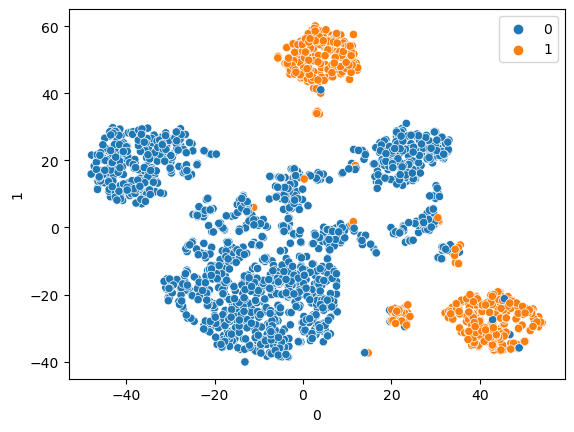

In [149]:
df = pd.DataFrame(X_embedded)
sns.scatterplot(df, x=0, y=1, hue=labels)

Выбросы портят точность?

In [150]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=2)
outliers = clf.fit_predict(features)
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 231, 1809], dtype=int64))

Предположим что данная часть данных является выбросами.
Также учтем что t-sne смог хорошо сжать пространство -> есть наиболее информативные признаки, попробуем их найти

In [151]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
X_embedded = pca.fit_transform(features)

<AxesSubplot:xlabel='0', ylabel='1'>

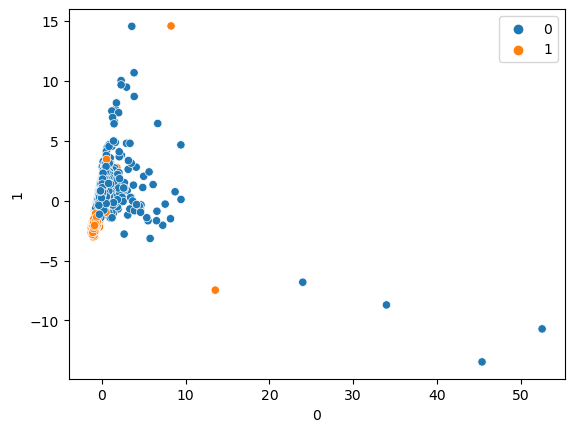

In [152]:
df = pd.DataFrame(X_embedded)
sns.scatterplot(df, x=0, y=1, hue=labels)

In [153]:
pca.components_.shape

(10, 20)

10 признаков много, можно было бы и меньше. Пять?

In [154]:
pca.explained_variance_ratio_

array([0.21088714, 0.13595075, 0.10456223, 0.07942934, 0.07549919,
       0.06905678, 0.06591472, 0.05672288, 0.05105561, 0.04268174])

Выберем признаки которые вносят наибольший ипакт в собственные вектора

In [155]:
important_features = [np.abs(pca.components_[i]).argmax() for i in range(pca.n_components)]
important_features

[13, 7, 9, 11, 16, 5, 6, 17, 14, 19]

Получили список наиболее информативных признаков по версии собственных векторов

In [156]:
features_df.columns[important_features]

Index(['listed_growth_rate', 'is_verified', 'tweets_freq',
       'friends_growth_rate', 'num_digits_in_screen_name',
       'is_default_profile', 'is_profile_use_background_image',
       'length_of_name', 'followers_friends_ratio', 'description_length'],
      dtype='object')

Соберем все вместе

In [157]:
def data_cleanup(features: np.ndarray, labels: np.ndarray) -> List[np.ndarray]:
    # Step 1: get rid of outliers
    clf = LocalOutlierFactor(n_neighbors=2)
    outliers = clf.fit_predict(features)
    print("Number of outliers to be deleted: ", np.unique(outliers, return_counts=True)[1])
    
    features_wo_outliers = np.delete(features, outliers, axis=0)
    labels_wo_outliers = np.delete(labels, outliers, axis=0)

    # Step 2: get rid of imbalance
    n_first, n_second = np.unique(labels_wo_outliers, return_counts=True)[1]
    ratio = n_second / n_first
    print("Unbalanced ratio", ratio, n_first, n_second)

    def dropout(label):
        return label == 1 or label == 0 and np.random.rand() > (1 - ratio)

    balanced_labels_data = np.array([(idx, l) for idx, l in enumerate(labels_wo_outliers) if dropout(l)])
    print("Number of classes after data balancing: ", np.unique(balanced_labels_data[..., 1], return_counts=True)[1])
    balanced_labels_indices = balanced_labels_data[..., 0]
    balanced_labels = balanced_labels_data[..., 1]
    balanced_features = features_wo_outliers[balanced_labels_indices]

    # Step 3: Only important features
    clean_features = balanced_features[..., important_features]

    return clean_features, balanced_labels

In [158]:
ideal_features, ideal_labels = data_cleanup(features, labels)

Number of outliers to be deleted:  [ 231 1809]
Unbalanced ratio 0.3311561071195297 1531 507
Number of classes after data balancing:  [483 507]


In [159]:
params = best_model.get_params()
params['max_iter'] = 1000

In [160]:
scores, _ = perform_test(params, ideal_features, ideal_labels)
np.mean(scores)  # В среднем стало лучше

0.9921371677078751

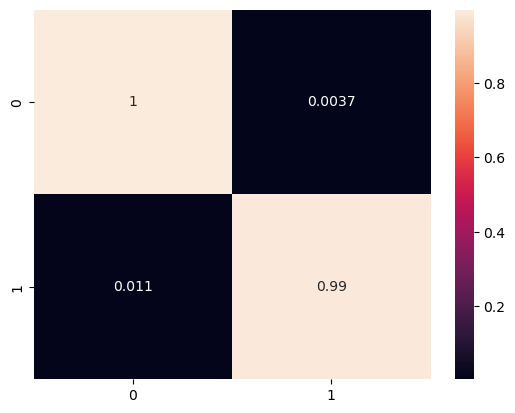

In [164]:
model = perform_test_with_confusion_matrix(params, ideal_features, ideal_labels, val_features[..., important_features], val_labels)

Согласно заданию - нас интересует false-positive значение, которое меньше чем необходимый порог в 0.03

In [165]:
with open('models/best_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [166]:
np.save('important_features_indices.npy', important_features)